# Plantilla: Proyecto
## Tema 2: Clasificación de barrios en función de su tipología.
Documento plantilla para el proyecto con los imports de las librerias más importantes.

In [1]:
import nltk                      # Natural Language Toolkit
import scrapy                    # Web scraping   
import requests                  # HTTP requests
import selenium                  # Web automation
import numpy as np               # Numerical computing
import pandas as pd              # Data manipulation
import seaborn as sns            # Data visualization
import tensorflow as tf          # Machine learning
import matplotlib.pyplot as plt  # Data visualization
import os                        # Operating system

!pip install openpyxl
import openpyxl                  # Excel files
import zipfile                   # Zip files
from copy import deepcopy        # Copy objects

# Automatización en la recogida de variables (dataset Barris)

Primero crearemos el diccionario `barrios_dict` donde se haga la asignación entre los nombres de los Barrios y el par distrito-barrio.

In [2]:
idBarrios = pd.read_csv('./data/barrios/barrios_codigos.csv', delimiter=';')
idBarrios = idBarrios[['Nombre', 'Codigo distrito', 'Codigo barrio']]

barrios_dict = {}

for index, row in idBarrios.iterrows():
    nombre = row['Nombre']
    codigo_distrito = row['Codigo distrito']
    codigo_barrio = row['Codigo barrio']
    
    barrio_dict = {
        'Codigo distrito': codigo_distrito,
        'Codigo barrio': codigo_barrio
    }
    
    barrios_dict[nombre] = barrio_dict

Definimos la función `get_barrio_name` que nos permite realizar la asignación distrito-barrio -> nombre del barrio.

In [3]:
def get_barrio_name(codigo_distrito, codigo_barrio):
    for nombre, barrio_dict in barrios_dict.items():
        if barrio_dict['Codigo distrito'] == codigo_distrito and barrio_dict['Codigo barrio'] == codigo_barrio:
            return nombre

Definimos a continuación unas funciones que nos ayudarán a extraer correctamente las tablas de las variables deseadas de los distintos excel.

In [4]:
def find_string_in_df(df, string):
    for i in range(len(df)):
        if string in str(df.iloc[i, 0]):
            return i
    return None

def find_skip(df, row):
    # Encontrar la primera fila que no esté completamente llena de NAs después de la fila especificada
    for i in range(row + 2, len(df)): # el +2 en lugar de +1 es para poder ponerlo en castellano xD
        if not df.iloc[i].isna().all():
            return i - row

    return 0  # Si todas las filas después de 'row' están completamente llenas de NAs, skip es 0

def extract_df(df, row, skip, n=None):
    if n is None:
        # Encontrar n dinámicamente.
        last_row = row + skip
        while last_row < len(df) and not df.iloc[last_row].isna().all():
            last_row += 1
        n = last_row - row - skip
    extracted_df = df.iloc[row + skip:row + skip + n, :]
    
    # Verificar si TODAS las filas en cada columna son NA
    columns_to_drop = extracted_df.columns[extracted_df.isna().all()]
    
    # Eliminar solo las columnas donde todas las filas son NA
    extracted_df = extracted_df.drop(columns_to_drop, axis=1)
    
    return extracted_df

def extract_df_by_string(df, string, n=None):
    row = find_string_in_df(df, string)
    skip = find_skip(df, row)
    return extract_df(df, row, skip, n)

In [5]:
#dataframes = { 'dfSup': dfSup,
#                    'dfPobSexEdad': dfPobSexEdad,
#                    'dfPobSexLugar': dfPobSexLugar,
#                    'dfPobExtCont': dfPobExtCont,
#                    'dfHojasFamComp': dfHojasFamComp,
#                    'dfIndicadoresDemograficosPadron': dfIndicadoresDemograficosPadron,
#                    'dfMovPadron': dfMovPadron,
#                    'dfIndicadoresDemograficosMovPadron': dfIndicadoresDemograficosMovPadron,
#                    'dfVehicTipo': dfVehicTipo,
#                    'dfTurismPot': dfTurismPot,
#                    'dfBienesInmAno': dfBienesInmAno,
#                    'dfBienesInmSup': dfBienesInmSup,
#                    'dfBienesInmVal': dfBienesInmVal,
#                    'dfBienesValMedio': dfBienesValMedio,
#                    'dfSupAparc': dfSupAparc,
#                    'dfElecGen': dfElecGen
#                 }

Se definen a continuación funciones para hacer un preprocesamiento de los diferentes datos que se adquirirán.

In [6]:
def clean_dataframe(df):
    # Eliminar filas y columnas con todos los valores NaN
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    # Establecer la primera fila como nombres de columnas y reindexar
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    return df

def modify_first_column_name(df, column_name):
    df.columns = [column_name] + list(df.columns[1:])
    return df
        
def extract_dataframes_from_excel(excel_path):
    dataframes = {}
    sheets = {
        'Padrón': ['Superficie y densidad de población', 'Población por sexo y edad (grandes grupos)',
                   'Población según lugar de nacimiento y sexo', 'Población extranjera según nacionalidad, por contienentes',
                   'Número de hojas familiares según composición', 'Indicadores demográficos'],
        'MovPadrón': ['Resumen de movimientos registrados en el Padrón Municipal', 'Indicadores demográficos'],
        'Vehículos': ['Vehículos según tipo', 'Turismos según potencia'],
        'Catastro': ['Bienes Inmuebles según el año de antigüedad',
                     'Bienes Inmuebles construidas después de 1800 según superficie construida',
                     'Bienes Inmuebles construidas después de 1800 según valor catastral',
                     'Valores catastrales medios', 'Superficie total de los aparcamientos'],
        'Elecciones': ['Votos a candidaturas']
    }
    
    for sheet, strings in sheets.items():
        df_sheet = pd.read_excel(excel_path, sheet_name=sheet)
        for string in strings:
            df = extract_df_by_string(df_sheet, string)
            if df is not None:
                df = clean_dataframe(df)
                if sheet == 'Padrón' and string in ['Población por sexo y edad (grandes grupos)', 'Población según lugar de nacimiento y sexo', 'Población extranjera según nacionalidad, por contienentes']:
                    modify_first_column_name(df, 'Género')
                elif sheet == 'Vehículos' and string == 'Vehículos según tipo':
                    modify_first_column_name(df, 'Tipo de vehículo')
                elif sheet == "Vehículos" and string == "Turismos según potencia":
                    modify_first_column_name(df, 'Potencia')
                elif sheet == 'Elecciones' and string == 'Votos a candidaturas':
                    modify_first_column_name(df, 'Partido')
                dataframes[f'{sheet}_{string.replace(" ", "_")}'] = df
    
    return dataframes


Esta función permite sacar el nombre del barrio infiriéndolo por el nombre del Excel (sigue la estructura de `Distrito_{num_distrito}_Barrio_{num_barrio}.xlsx`).

In [7]:
def get_barrio_name_from_filename(filename, barrios_dict):
    # Extraer el nombre del distrito y el número de barrio del nombre del archivo
    distrito_numero, barrio_numero = os.path.splitext(filename)[0].split('_')[1:4][::2]
    
    # Buscar el nombre del distrito y el número de barrio en barrios_dict
    for nombre, info_barrio in barrios_dict.items():
        if info_barrio['Codigo distrito'] == int(distrito_numero) and info_barrio['Codigo barrio'] == int(barrio_numero):
            return nombre
    
    return None

Se definen a continuación funciones que nos permitirán realizar el proceso de creación de la carpeta para un año concreto, descarga del zip correspondiente y su descompresión automática.

In [8]:
def download_zip(year):
    url = f'https://www.valencia.es/estadistica/inf_dtba/{year}/Barrios{year}.zip'
    response = requests.get(url)
    with open(f'./data/barrios/{year}/{year}.zip', 'wb') as file:
        file.write(response.content)

def create_folder(year):
    folder_path = f'./data/barrios/{year}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
def unzip_file(year):
    with zipfile.ZipFile(f'./data/barrios/{year}/{year}.zip', 'r') as zip_ref:
        zip_ref.extractall(f'./data/barrios/{year}')
        
def download_and_unzip(year):
    create_folder(year)
    download_zip(year)
    unzip_file(year)
    

Finalmente, la función `get_data` permite recibir una lista de años y devuelve los datos correctamente preprocesados ya para las variables que nos interesan.

In [9]:
def get_data(years):
    datos = {}
    for year in years:
        download_and_unzip(year)
        datos[year] = {}
        for filename in os.listdir(f'./data/barrios/{year}'):
            if filename.endswith('.xlsx'):
                excel_path = os.path.join(f'./data/barrios/{year}', filename)
                dataframes = extract_dataframes_from_excel(excel_path)
                barrio_name = get_barrio_name_from_filename(filename, barrios_dict)
                datos[year][barrio_name] = dataframes
    return datos

In [10]:
# Probar con lista de [2023, 2024] como year

years = [2023]

datosBarris = get_data(years)

In [11]:
datosBarris[2023]['LA SEU']['Vehículos_Turismos_según_potencia']

,Potencia,Turismos / Turismes
0,Total,2316
1,Menos de 8 CV,113
2,"De 8 a 11,99 CV",1051
3,"De 12 a 15,99 CV",975
4,"De 16 CV a 19,99 CV",148
5,De 20 CV y más,29


In [13]:
datosBarris[2023]['BENICALAP']['Elecciones_Votos_a_candidaturas']

,Partido,Total
0,PARTIDO POPULAR,6553
1,COMPROMÍS PER VALÈNCIA: ACORD PER GUANYAR,4880
2,PARTIDO SOCIALISTA OBRERO ESPAÑOL,4689
3,VOX,2676
4,UNIDES PODEM-ESQUERRA UNIDA,448
5,CIUDADANOS-PARTIDO DE LA CIUDADANIA,408
6,PARTIDO ANIMALISTA CON EL MEDIO AMBIENTE (PACMA),216
7,VALENCIA UNIDA,96
8,ESCAÑOS EN BLANCO PARA DEJAR ESCAÑOS VACÍOS,30
9,PARTIDO COMUNISTA DE LOS PUEBLOS DE ESPAÑA,27


# Tidyficación para introducción en modelos

In [14]:
# Mirar keys de datosBarris
datosBarris[2023]['LA SEU'].keys()

dict_keys(['Padrón_Superficie_y_densidad_de_población', 'Padrón_Población_por_sexo_y_edad_(grandes_grupos)', 'Padrón_Población_según_lugar_de_nacimiento_y_sexo', 'Padrón_Población_extranjera_según_nacionalidad,_por_contienentes', 'Padrón_Número_de_hojas_familiares_según_composición', 'Padrón_Indicadores_demográficos', 'MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal', 'MovPadrón_Indicadores_demográficos', 'Vehículos_Vehículos_según_tipo', 'Vehículos_Turismos_según_potencia', 'Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad', 'Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida', 'Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral', 'Catastro_Valores_catastrales_medios', 'Catastro_Superficie_total_de_los_aparcamientos', 'Elecciones_Votos_a_candidaturas'])

In [39]:
datosBarris_tidy = deepcopy(datosBarris) # deepcopy es para que no se modifique el original, aplicable a objetos que contienen referencias a otros objetos

for year in years:
    for barrio in datosBarris_tidy[year].keys():
        
        # Padrón_Superficie_y_densidad_de_población --> hecho, cada variable está en una columna
        
        # Padrón_Población_por_sexo_y_edad_(grandes_grupos)
        
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Padrón_Población_por_sexo_y_edad_(grandes_grupos)'])
        df_aux['Porcentaje +65 años'] = df_aux['65 y más'] / df_aux['Total'] * 100
        datosBarris_tidy[year][barrio]['Padrón_Población_por_sexo_y_edad_(grandes_grupos)'] = df_aux[['Porcentaje +65 años']].head(1)
        
        # Padrón_Población_según_lugar_de_nacimiento_y_sexo -> nada relevante, en principio (borrar, ese dataframe de dentro de datosBarris_tidy)
        
        del datosBarris_tidy[year][barrio]['Padrón_Población_según_lugar_de_nacimiento_y_sexo']
        
        # Padrón_Población_extranjera_según_nacionalidad,_por_contienentes -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['Padrón_Población_extranjera_según_nacionalidad,_por_contienentes']
        
        # Padrón_Número_de_hojas_familiares_según_composición -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['Padrón_Número_de_hojas_familiares_según_composición']
        
        # Padrón_Indicadores_demográficos
        posiciones_variables = {
        'Edad media': 1,
        'Índice de envejecimiento': 2,
        'Índice de sobreenvejecimiento': 3,
        'Índice de estructura de la población activa': 5,
        'Porcentaje de población extranjera': 8
        }

        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Padrón_Indicadores_demográficos'])
        df_aux['Edad media'] = df_aux.iloc[posiciones_variables['Edad media'], 1]
        df_aux['Índice de envejecimiento'] = df_aux.iloc[posiciones_variables['Índice de envejecimiento'], 1]
        df_aux['Índice de sobreenvejecimiento'] = df_aux.iloc[posiciones_variables['Índice de sobreenvejecimiento'], 1]
        df_aux['Índice de estructura de la población activa'] = df_aux.iloc[posiciones_variables['Índice de estructura de la población activa'], 1]
        df_aux['Porcentaje de población extranjera'] = df_aux.iloc[posiciones_variables['Porcentaje de población extranjera'], 1]
        
        df_aux = df_aux.drop(df_aux.columns[[0, 1]], axis=1).head(1)
        datosBarris_tidy[year][barrio]['Padrón_Indicadores_demográficos'] = df_aux
        
        # MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['MovPadrón_Resumen_de_movimientos_registrados_en_el_Padrón_Municipal']
        # MovPadrón_Indicadores_demográficos -> nada relevante, en principio
        
        del datosBarris_tidy[year][barrio]['MovPadrón_Indicadores_demográficos']
        
        # Vehículos_Vehículos_según_tipo -> difícil de interpretar, no le veo del todo utilidad
        
        del datosBarris_tidy[year][barrio]['Vehículos_Vehículos_según_tipo']
        
        # Vehículos_Turismos_según_potencia -> difícil de interpretar
        
        del datosBarris_tidy[year][barrio]['Vehículos_Turismos_según_potencia']

        # Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad, necesito 
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad'])
        df_aux = df_aux.drop(columns = ['Total'])
        max_column = df_aux.iloc[0].idxmax()
        df_aux["AñoInmuebleFrec"] = max_column
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_según_el_año_de_antigüedad'] = df_aux[['AñoInmuebleFrec']].head(1)
        
        # Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida'])[['Sup. construida media (m²)']]
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_superficie_construida'] = df_aux.head(1)
        
        # Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral
        # Hacer algo similar que lo de hallar término con más frecuencia
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral'])
        df_aux = df_aux.drop(columns = ['Total'])
        max_column = df_aux.iloc[0].idxmax()
        df_aux["ValorCatastralFrec"] = max_column
        
        datosBarris_tidy[year][barrio]['Catastro_Bienes_Inmuebles_construidas_después_de_1800_según_valor_catastral'] = df_aux[['ValorCatastralFrec']].head(1)
        
        # Catastro_Valores_catastrales_medios
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Catastro_Valores_catastrales_medios'])[['Valor por m²']]
        
        datosBarris_tidy[year][barrio]['Catastro_Valores_catastrales_medios'] = df_aux.head(1)
        
        # Catastro_Superficie_total_de_los_aparcamientos -> no la veo muy relevante
        
        del datosBarris_tidy[year][barrio]['Catastro_Superficie_total_de_los_aparcamientos']
        
        # Elecciones_Votos_a_candidaturas
        df_aux = deepcopy(datosBarris_tidy[year][barrio]['Elecciones_Votos_a_candidaturas'])
        # Sacar el partido con más votos (fila 0), columna 'Partido'
        df_aux = df_aux.drop(columns = ['Total'])
        
        datosBarris_tidy[year][barrio]['Elecciones_Votos_a_candidaturas'] = df_aux.head(1)
        
        # MERGE de todos los dataframes anteriores
        
        datosBarris_tidy[year][barrio] = pd.concat([datosBarris_tidy[year][barrio][key] for key in datosBarris_tidy[year][barrio].keys()], axis=1)

In [42]:
datosBarris_tidy[2023]['BENICALAP']

,Personas / Persones,Superficie / Superfície,Densidad de población / Densitat de població,Porcentaje +65 años,Edad media,Índice de envejecimiento,Índice de sobreenvejecimiento,Índice de estructura de la población activa,Porcentaje de población extranjera,AñoInmuebleFrec,Sup. construida media (m²),ValorCatastralFrec,Valor por m²,Partido
0,42725,171.895,248.552896,18.291398,43,120.2,13.9,137.9,16.5,1961-80,104.176912,36-48,408.03034,PARTIDO POPULAR


## Visualización de algunas variables

In [48]:
def plot_histogram(datos, year, variable, bins=20, kde = True, color='skyblue', title=None):
    # Obtener todos los valores de la columna 'Personas / Persones' en todos los barrios
    valores = []
    for barrio in datos[year].keys():
        valores.extend(datos[year][barrio][variable])

    # Crear el histograma
    plt.figure(figsize=(10, 6))
    sns.histplot(valores, bins=bins, kde=kde, color=color)

    # Añadir etiquetas y título
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    if title is None:
        plt.title(f'Histograma de {variable} por Barrio')
    else:
        plt.title(title)

    plt.show()

c:\Users\jesus\anaconda3\envs\NLP_310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


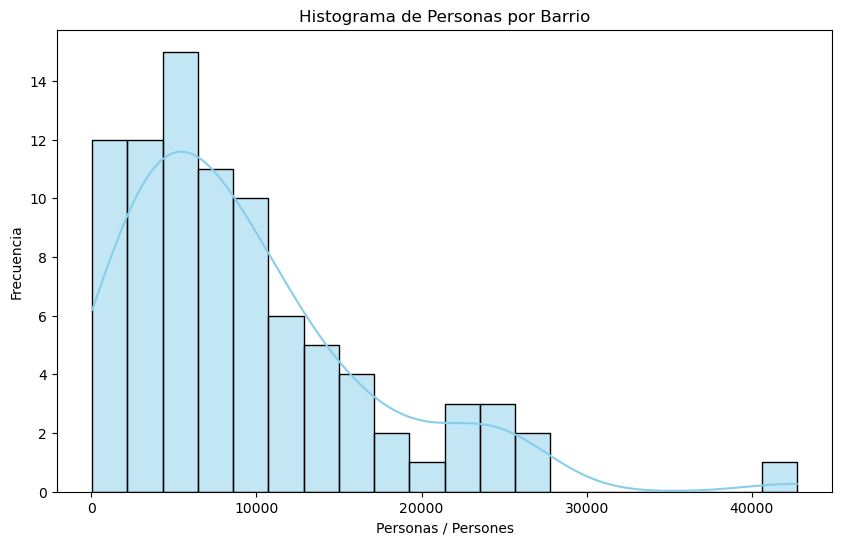

In [49]:
plot_histogram(datosBarris_tidy, 2023, 'Personas / Persones', bins = 20, kde = True, color = 'skyblue', title = 'Histograma de Personas por Barrio')